# Koan 8 — Train a variational autoencoder (VAE)

Variational autoencoders learn how to embed items into a vector space
where similar inputs tend to cluster together, and dissimilar inputs
tend to be separated. A full VAE includes both an encoder, mapping
inputs into the latent space, as well as a decoder, mapping the latent
space back to the original input space.

The purpose of this notebook is to train a VAE and to observe how well
it's working. I'll work with the fashion MNIST data set, which has
small 28x28 images of articles of clothing, along with 10 labels
(such as "sneaker," "coat," "sandal," and so on). I won't use the
labels to train, only the images themselves.

There are several ways to see that the VAE is working:
* You can observe that **the reconstructed image from an input looks like the original image**,
  even if
  some details change (because the model is like a lossy compression and decompression).
* You can see that **there is some continuity in the latent space**. I'll use the decoder to
  make a grid of images. Neighbors in the grid will be decoded from nearby latent vectors. If
  the VAE is successful, then nearby images will look similar, even when the endpoints are
  in different categories, such as interpolating between a shoe and a shirt.
* Finally, we can check that **the latent space tends to cluster similar items
  together**, and tends to separate dissimilar items.
  Mere mortals can't easily see into a 30-dimensional
  space (a friend of mine tried once and he still acts a little funny to this day). So
  I'll use t-SNE to embed the latent vectors into a human-friendly 2d space, where it's
  easier to draw a scatter plot with each clothing image's point color-coded by what kind
  of thing it is ("sneaker," "sandal," etc). If the VAE clusters well, then we should see that
  dots of the same color tend to be close together, whiel these groups tend to be well-separated.

In practice, you might end up with some categories mixing together in such a scatter plot.
This can happen when most categories are clearly distinct as unlabeled inputs (such as
"shoe" and "pants"), while other categories are less distinct (such as "coat" and "pullover").

___
**Note**

You may need to install the `lpips` library:

```
python -m pip install lpips
```

(A simple `pip install` can also work, but I prefer to run `pip` as above
to help ensure that my installation matches the instance of Python I'm
working with, such as `python3` or `ipython3`, etc.)
___

## Imports

In [1]:
# Jupyter directives
%matplotlib inline

# Standard library imports
import time
import re

# Pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Third-party imports
from   IPython.display import HTML
import lpips
import matplotlib.pyplot as plt
from   matplotlib.animation import FuncAnimation
import numpy as np
from   sklearn.manifold import TSNE
from   tqdm import tqdm

## Hyperparameters

It's convenient to keep this up top so it's easy to
re-run the full notebook with different values.

In [2]:
# Hyperparameters
latent_dim = 30
batch_size = 128

# I'll use various learning rates as part of a training
# schedule below.

## Load the fashion MNIST data

In [3]:
# Load fashion-MNIST as both datasets and dataloaders.

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.FashionMNIST(root='./data', train=True,  transform=transform, download=True)
test_dataset  = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

In [4]:
# Inspect a single element to see what this data is like.
image, label = train_dataset[0]
image.shape, label

(torch.Size([1, 28, 28]), 9)

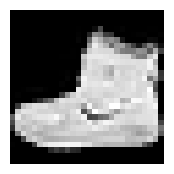

In [5]:
# Let's see an example image.
plt.figure(figsize=(2, 2))
plt.axis('off')
plt.imshow(image.squeeze(), cmap='gray');

In [6]:
# What is this thing?
classes = datasets.FashionMNIST.classes
classes[label]

'Ankle boot'

In [7]:
# Ah, of course, an ankle boot.

## Define the model

In [8]:
# Define the VAE class

class VAE(nn.Module):

    def __init__(self, latent_dim):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )

        self.mu_layer = nn.Linear(256, latent_dim)
        self.log_var_layer = nn.Linear(256, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid()  # Output values in the [0, 1] range.
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.mu_layer(h)
        log_var = self.log_var_layer(h)
        return mu, log_var

    def reparametrize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.rand_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        mu, log_var = self.encode(x)
        z = self.reparametrize(mu, log_var)
        recon = self.decode(z)
        return recon, mu, log_var

## Define our loss function

This loss function has two parts, one to encourage the
reconstructed image to be similar to the input image,
and another to encourage the values of `mu` and `log_var` to
be close to a standard normal distribution.

The reconstruction loss (`recon_loss`) uses a library called lpips,
which stands for learned perceptual image patch similarity.
You could train this VAE with a more standard pixel loss value, such
as MSE (mean squared error) or binary cross entropy. The lpips
library is useful because its error function is closer to what a
human would provide when given two images, and scoring their
similarity. The `lpips` loss function is relatively slow, so
this is a tradeoff: training is slower, but the resulting model
will be a little better.

In [9]:
# Define our computation device (eg cpu, cuda, or mps for Apple silicon).
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
)

In [10]:
# Define the VAE loss function.

vgg_loss_fn = lpips.LPIPS(net='vgg').to(device)

def vae_loss(recon_x, x, mu, log_var):

    recon_loss = vgg_loss_fn(recon_x.view(-1, 1, 28, 28), x.view(-1, 1, 28, 28)).sum()

    # This is a faster alternative:
    # recon_loss = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28 * 28), reduction='sum')
    
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    # Downweight the KL divergence; otherwise it overwhelms the loss, and the
    # reconstruction is low quality.
    return recon_loss + 1e-3 * kl_div

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.11/site-packages/lpips/weights/v0.1/vgg.pth


## Define training and evaluation functions

In [11]:
# Core training function

def train_one_epoch(model, loader):

    global device, opt, vae_loss
    
    model.train()
    total_loss = 0
    for x, _ in tqdm(loader, ncols=60):
        x = x.to(device)
        opt.zero_grad()
        recon, mu, log_var = model(x)
        loss = vae_loss(recon, x, mu, log_var)
        loss.backward()
        opt.step()
        total_loss += loss.item()

    return total_loss / len(loader)        

In [12]:
# Core evaluation function

def evaluate(model, loader):

    global device, vae_loss

    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            recon, mu, log_var = model(x)
            loss = vae_loss(recon, x, mu, log_var)
            total_loss += loss.item()

    return total_loss / len(loader)

In [13]:
# Convenience functions to make training easier

def set_learning_rate(lr):
    global opt
    for param_group in opt.param_groups:
        param_group['lr'] = lr
    print(f'lr set to {lr}')

def train_w_schedule(sch):
    ''' This expects `sch` to be a training schedule, which is a list that
        alternates between a learning rate, and a number of epochs for that rate.
        Example: [1e-5, 10, 1e-6, 10].
    '''
    while len(sch) > 0:
        lr, n_epochs = sch[:2]
        
        set_learning_rate(lr)

        for ep in range(n_epochs):
            t_loss = train_one_epoch(model, train_loader)
            e_loss = evaluate(model, test_loader)
            print(f'Epoch [{ep + 1:2d}/{n_epochs}]. Train Loss: {t_loss:.5f}. Eval Loss: {e_loss:.5f}')

        del sch[:2]

## Create and train the model

In [14]:
model = VAE(latent_dim).to(device)
opt   = optim.Adam(model.parameters())  # We'll set the learning rate below.

In [15]:
%%time

# On my macbook (M2), this takes about 20 minutes to train.
print('Started at', time.strftime('%b %d %H:%M'))
train_w_schedule([5e-3, 5, 1e-3, 10])

Started at Jan 05 23:16
lr set to 0.005


100%|█████████████████████| 469/469 [01:07<00:00,  6.93it/s]


Epoch [ 1/5]. Train Loss: 28.00417. Eval Loss: 21.02790


100%|█████████████████████| 469/469 [01:06<00:00,  7.10it/s]


Epoch [ 2/5]. Train Loss: 19.91665. Eval Loss: 18.81617


100%|█████████████████████| 469/469 [01:05<00:00,  7.19it/s]


Epoch [ 3/5]. Train Loss: 18.36347. Eval Loss: 17.99198


100%|█████████████████████| 469/469 [01:07<00:00,  7.00it/s]


Epoch [ 4/5]. Train Loss: 17.71554. Eval Loss: 17.44057


100%|█████████████████████| 469/469 [01:06<00:00,  7.00it/s]


Epoch [ 5/5]. Train Loss: 17.26647. Eval Loss: 17.06926
lr set to 0.001


100%|█████████████████████| 469/469 [01:06<00:00,  7.07it/s]


Epoch [ 1/10]. Train Loss: 16.36524. Eval Loss: 16.21711


100%|█████████████████████| 469/469 [01:06<00:00,  7.04it/s]


Epoch [ 2/10]. Train Loss: 16.14883. Eval Loss: 16.07924


100%|█████████████████████| 469/469 [01:06<00:00,  7.06it/s]


Epoch [ 3/10]. Train Loss: 16.02640. Eval Loss: 15.98890


100%|█████████████████████| 469/469 [01:05<00:00,  7.15it/s]


Epoch [ 4/10]. Train Loss: 15.91577. Eval Loss: 15.90134


100%|█████████████████████| 469/469 [01:05<00:00,  7.16it/s]


Epoch [ 5/10]. Train Loss: 15.82256. Eval Loss: 15.83175


100%|█████████████████████| 469/469 [01:05<00:00,  7.18it/s]


Epoch [ 6/10]. Train Loss: 15.73284. Eval Loss: 15.68024


100%|█████████████████████| 469/469 [01:05<00:00,  7.15it/s]


Epoch [ 7/10]. Train Loss: 15.65229. Eval Loss: 15.65095


100%|█████████████████████| 469/469 [01:06<00:00,  7.10it/s]


Epoch [ 8/10]. Train Loss: 15.57946. Eval Loss: 15.58847


100%|█████████████████████| 469/469 [01:06<00:00,  7.10it/s]


Epoch [ 9/10]. Train Loss: 15.50781. Eval Loss: 15.54474


100%|█████████████████████| 469/469 [01:05<00:00,  7.13it/s]


Epoch [10/10]. Train Loss: 15.44369. Eval Loss: 15.45817
CPU times: user 6min 7s, sys: 31.3 s, total: 6min 39s
Wall time: 18min 14s


## Visually check the reconstruction quality

In [16]:
# A function to display a grid of images.

def show_image_grid(imgs):
    nrows = len(imgs)
    ncols = len(imgs[0])
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols, nrows))
    if nrows == 1: axs = [axs]
    for i, row in enumerate(imgs):
        for j, img in enumerate(row):
            axs[i][j].imshow(img.cpu().view(28, 28), cmap='gray')
            axs[i][j].axis('off')
    plt.tight_layout()
    plt.show()

In [17]:
def visualize_reconstructions(model, loader):

    n = 10

    model.eval()
    x, _ = next(iter(loader))
    x = x[:n].to(device)
    with torch.no_grad():
        recon, _, _ = model(x)
    recon = recon.view(-1, 1, 28, 28).cpu()
    x = x.cpu()

    show_image_grid([list(x), list(recon)])

### Sample reconstructions of training data

* Top row = originals
* Bottom row = reconstructions

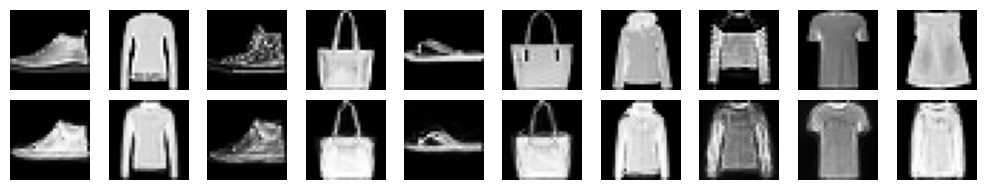

In [18]:
visualize_reconstructions(model, train_loader)

### Sample reconstructions of test data

* Top row = originals
* Bottom row = reconstructions

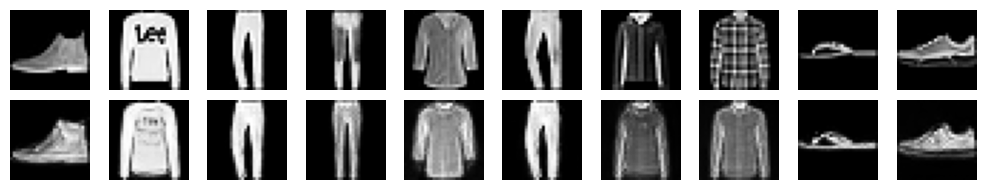

In [19]:
visualize_reconstructions(model, test_loader)

## Visually check continuity in the latest space

In [20]:
# I'll pick four training images that I'll interpolate between.
# Each of these images will be at one corner of a grid of images,
# with interpolations between them.
imgs = [train_dataset[i][0] for i in range(35, 39)]

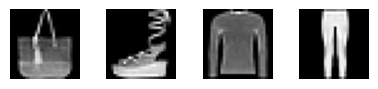

In [21]:
# Let's see the originals of the images I'll interpolate between.
show_image_grid([imgs])

In [22]:
# Calculate the latent vectors (the encodings) for the four
# corners, and then for all the points between on a grid.
with torch.no_grad():
    mus = [
        model.encode(img.to(device).view(-1, 28 * 28))[0].cpu()
        for img in imgs
    ]

N = 20  # the number of rows and cols in our grid

top_row_vecs = np.linspace(mus[0], mus[1], N)
bot_row_vecs = np.linspace(mus[2], mus[3], N)

all_vecs = np.linspace(top_row_vecs, bot_row_vecs, N)

In [23]:
# Decode those vectors to arrive at the image data.
with torch.no_grad():
    all_imgs = [
        [model.decode(torch.Tensor(vec).to(device)).cpu() for vec in vec_row]
        for vec_row in all_vecs
    ]

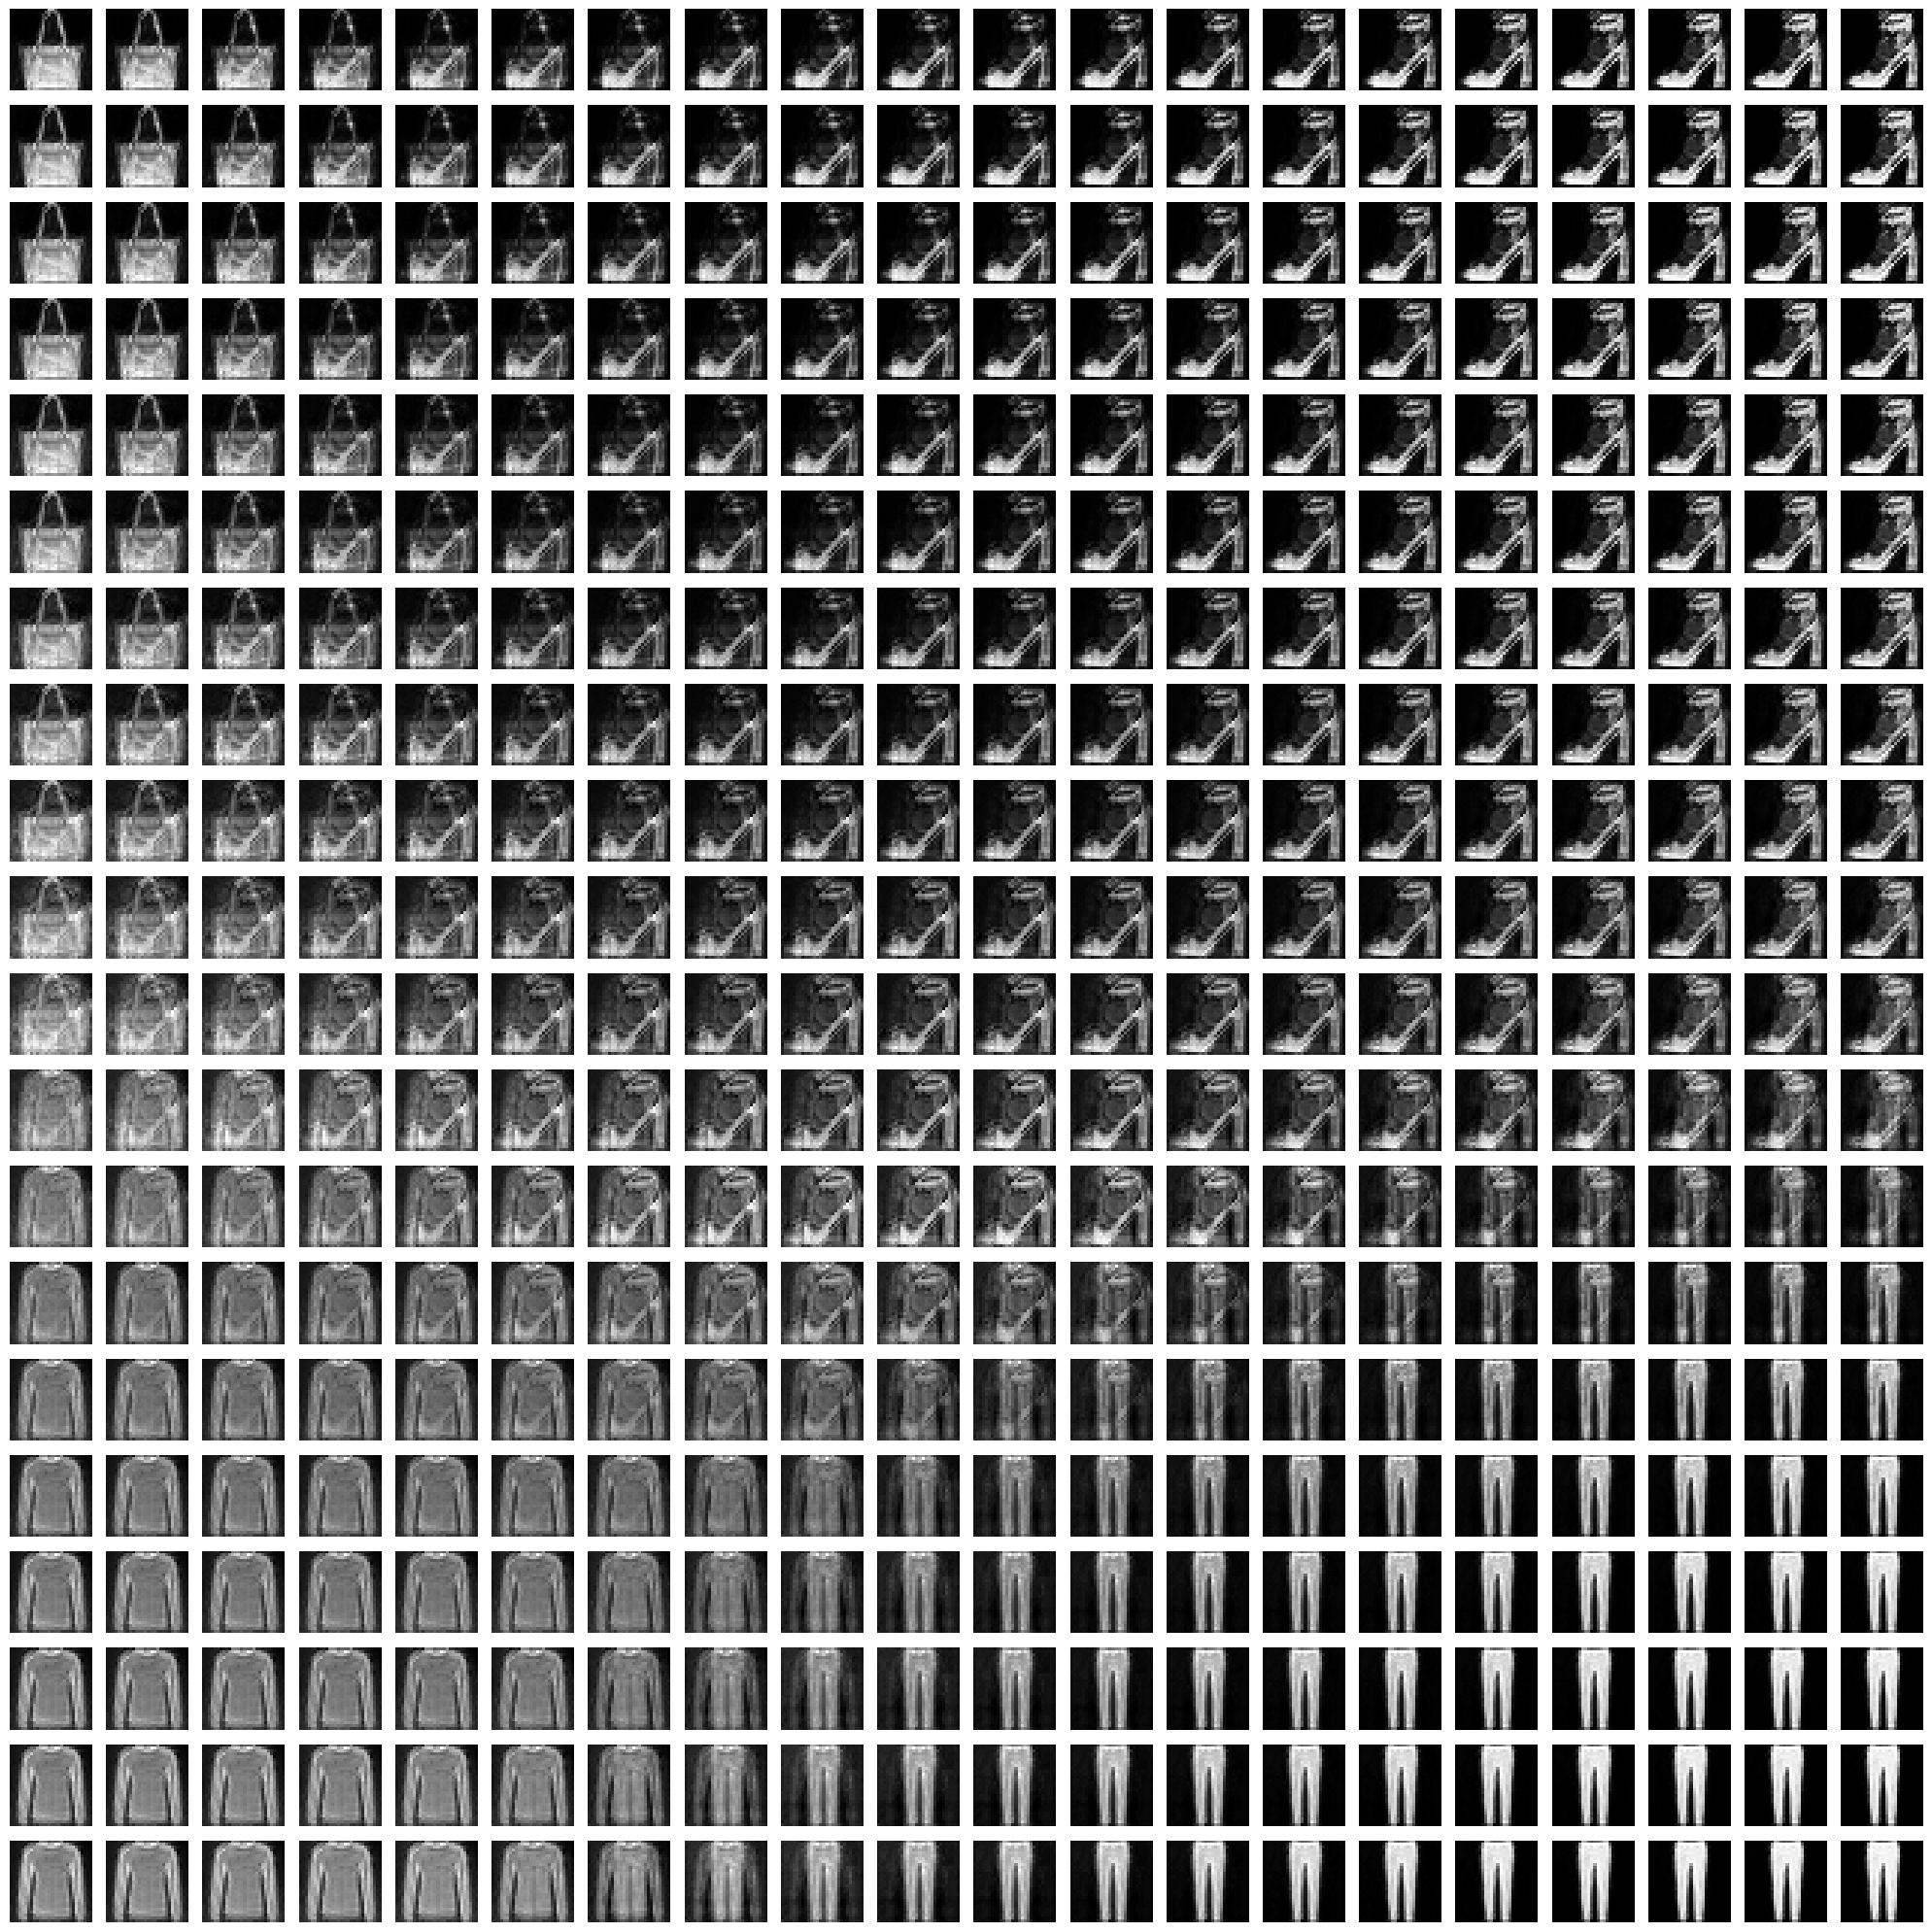

In [24]:
# Let's view the image grid.
show_image_grid(all_imgs)

In [25]:
# Make a function to animate the outside of the grid.

def animate_grid_outer_imgs(imgs):

    imgs = [[img.view(28, 28).cpu().numpy() for img in row] for row in imgs]
    nrows, ncols = len(imgs), len(imgs[0])

    path = [(0, i) for i in range(ncols)] + \
       [(i, ncols - 1) for i in range(nrows)] + \
       [(nrows - 1, i) for i in range(ncols - 1, -1, -1)] + \
       [(i, 0) for i in range(nrows - 1, 0, -1)]

    fig, ax = plt.subplots(figsize=(4, 4))
    img_display = ax.imshow(imgs[0][0], cmap='gray', vmin=0, vmax=1)
    ax.axis('off')

    def update(frame):
        i, j = path[frame % len(path)]
        img_display.set_data(imgs[i][j])
        return [img_display]

    anim = FuncAnimation(fig, update, frames=len(path), interval=100, blit=True, repeat=True)
    plt.close(fig)

    # This is an embarrassingly hacky way to make the animation auto-play.
    lines = anim.to_jshtml().split('\n')
    pattern = r'(\w+)\s*=\s*new\s+Animation'
    for i, line in enumerate(lines):
        m = re.search(pattern, line)
        if m:
            lines[i + 1] += f' {m.group(1)}.play_animation();'
    return HTML('\n'.join(lines))

In [26]:
animate_grid_outer_imgs(all_imgs)

## Look for category clustering in the latent space

It's difficult to see into 30-dimensional space, so I'll use t-SNE to
map the latent vectors down into 2d, and in a way that attempts to
preserve neighbor relationships (neighbors remain neighbors, and
non-neighbors remain non-neighbors).

In [27]:
# Define a function to plot t-SNE embeddings.

def make_tsne_plot(data, random_seed=42, custom_labels=None):

    # The data is expected to be in the format [(vec1, label1), (vec2, label2), ...]
    # with the vectors as numpy arrays. Separate out the vectors and labels.
    vecs, labels = zip(*data)
    vecs = np.array(vecs)

    # Compute the t-SNE-based 2d vectors.
    tsne = TSNE(
        n_components=2,
        random_state=random_seed,
        perplexity=30,
        n_iter=1_000,
        verbose=0,
        n_jobs=-1  # This means to use multiple CPU cores.
    )
    embedding = tsne.fit_transform(vecs)

    # Create a color-coded scatter plot with a legend.
    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        c=labels,
        cmap='tab10',
        s=1,
        alpha=0.6
    )
    nlabels = len(set(labels))
    cbar = plt.colorbar(
        scatter,
        ticks=np.arange(nlabels),
        boundaries=np.linspace(-0.5, 9.5, nlabels + 1)
    )
    if custom_labels is not None:
        cbar.ax.set_yticklabels(custom_labels)
    else:
        cbar.set_label('Labels')
        cbar.ax.set_yticklabels(range(nlabels))

    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.title('t-SNE Embedding of Latent Vectors')
    plt.show()

In [28]:
# Pull out all the latent vectors from the training set.
# On my macbook (M2), this takes about 40s.

num_pts = len(train_dataset)
data = []
with torch.no_grad():
    for i in tqdm(range(num_pts), ncols=60):
        img, label = train_dataset[i]
        mu, _ = model.encode(img.to(device).view(-1, 28 * 28))
        data.append((mu.cpu().view(-1).numpy(), label))

100%|███████████████| 60000/60000 [00:38<00:00, 1542.19it/s]


/usr/local/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


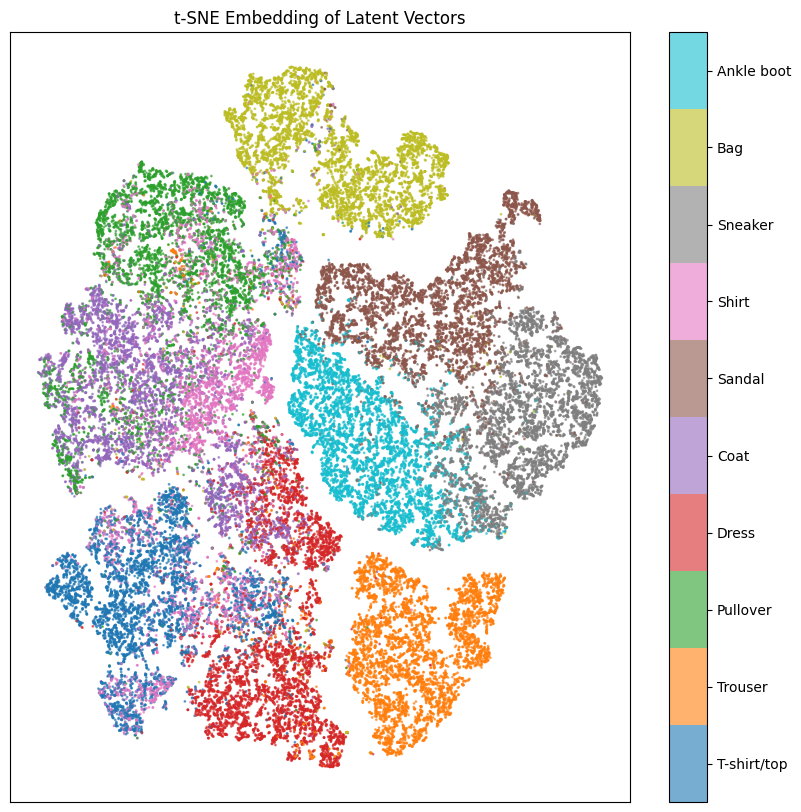

In [29]:
# Compute and plot the t-SNE-based 2d vectors.
# On my macbook (M2), this takes about 2 minutes.
make_tsne_plot(data, custom_labels=datasets.FashionMNIST.classes)